In [102]:
import networkx as nx
import matplotlib.pyplot as plt
import pprint
from pprint import pprint as pprint
import collections
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.schema import Table, DropTable
from beautifultable import BeautifulTable
import pandas as pd

In [2]:
Session = sessionmaker()
engine = create_engine('sqlite:///twitter.db')

In [3]:
# All distinct users

distinctUsers = pd.read_sql_query('SELECT user_id FROM user', engine)
print(len(distinctUsers))

42232


In [4]:
# Users whose posts had been retweeted

authorsOfRetweetedPosts = pd.read_sql_query(
                          'SELECT user1.user_name AS user \
                           FROM user AS user1 \
                           WHERE user1.user_id IN \
                                 (SELECT user2.user_id \
                                  FROM user AS user2 \
                                  INNER JOIN tweet ON tweet.user_id = user2.user_id \
                                  INNER JOIN retweet ON retweet.source_tweet_id = tweet.tweet_id)', engine)
print(len(authorsOfRetweetedPosts))

2827


In [5]:
# Users whose posts had never been retweeted

authorsOfNonRetweetedPosts = pd.read_sql_query(
                          'SELECT user1.user_name AS user \
                           FROM user AS user1 \
                           WHERE user1.user_id NOT IN \
                                 (SELECT user2.user_id \
                                  FROM user AS user2 \
                                  INNER JOIN tweet ON tweet.user_id = user2.user_id \
                                  INNER JOIN retweet ON retweet.source_tweet_id = tweet.tweet_id)', engine)
print(len(authorsOfNonRetweetedPosts))

39405


In [6]:
# Users who had retweeted posts of other users

retweetingUsers = pd.read_sql_query(
                            'SELECT user1.user_name AS user \
                             FROM user AS user1 \
                             WHERE user1.user_id IN \
                                 (SELECT user2.user_id \
                                  FROM user AS user2 \
                                  INNER JOIN retweet ON retweet.user_id = user2.user_id )', engine)
print(len(retweetingUsers))

35425


In [7]:
# Users who had never retweeted posts of other users

nonRetweetingUsers = pd.read_sql_query(
                            'SELECT user1.user_name AS user \
                             FROM user AS user1 \
                             WHERE user1.user_id NOT IN \
                                 (SELECT user2.user_id \
                                  FROM user AS user2 \
                                  INNER JOIN retweet ON retweet.user_id = user2.user_id )', engine)
print(len(nonRetweetingUsers))

6807


In [8]:
# Users whose posts had never been retweeted NEITHER had they retweeted posts of other users

doubleNonRetweeters = pd.read_sql_query(
                            'SELECT user1.user_name AS user \
                             FROM user AS user1 \
                             WHERE user1.user_id NOT IN \
                                 (SELECT user2.user_id \
                                  FROM user AS user2 \
                                  INNER JOIN tweet ON tweet.user_id = user2.user_id \
                                  INNER JOIN retweet ON retweet.source_tweet_id = tweet.tweet_id ) \
                            AND user1.user_id NOT IN \
                                 (SELECT user2.user_id \
                                  FROM user AS user2 \
                                  INNER JOIN retweet ON retweet.user_id = user2.user_id )', engine)
print(len(doubleNonRetweeters))

4962


In [9]:
# User - retwitter pairs

userPairs = pd.read_sql_query('SELECT user1.user_id AS user, COUNT(*) as number_of_retweets, \
                            user2.user_id AS retwitter \
                            FROM user AS user1 \
                             JOIN tweet ON tweet.user_id = user1.user_id \
                             JOIN retweet ON retweet.source_tweet_id = tweet.tweet_id \
                             JOIN user AS user2 ON retweet.user_id = user2.user_id \
                             WHERE retwitter IS NOT NULL \
                             GROUP BY user, retwitter', engine)
print(len(userPairs))

68520


In [10]:
# Full graph

G = nx.from_pandas_edgelist(userPairs, 'user', 'retwitter', edge_attr='number_of_retweets')
pprint(nx.info(G))

('Name: \n'
 'Type: Graph\n'
 'Number of nodes: 37270\n'
 'Number of edges: 68309\n'
 'Average degree:   3.6656')


In [11]:
# Get nodes with degree >= min_degree

min_degree = 7
nodes = [node for node, degree in G.degree() if degree >= min_degree]

In [12]:
# Create a subgraph with nodes degree >= min_degree (based on the G graph)

G_sampled = G.subgraph(nodes)
pprint(nx.info(G_sampled))

('Name: \n'
 'Type: Graph\n'
 'Number of nodes: 1845\n'
 'Number of edges: 13067\n'
 'Average degree:  14.1648')


In [14]:
def get_histogram(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    plt.show()

In [16]:
# Sampled graph used for further analysis

print("users", len(G_sampled.nodes))
print("connections",len(G_sampled.edges))

users 1845
connections 13067


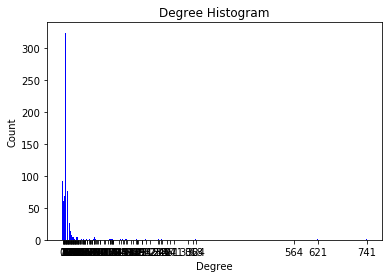

In [109]:
get_histogram(G_sampled)

In [111]:
from networkx.algorithms.community.centrality import girvan_newman
communities_iter = girvan_newman(G_sampled)

communities_sum = 0
communities_gn = []

for community_gn in next(communities_iter):
    communities_sum += 1
    communities_gn.append(community_gn)
    print("Community ", communities_sum)
    print(community_gn)
    print("Liczność community: ", len(community_gn), "\n")
    
print("Znaleziono communities: ", communities_sum)

Community  1
{705360231736344576, 812176014935588864, 880516946931859456, 926163797890555904, 1016015056645939200, 774631928745951232, 959797135158935553, 838114538868342787, 873808737743536132, 821077762509307910, 988667769024479239, 989567215878930437, 760293057929420803, 775625838385569796, 1055209982998863886, 758101519891914761, 946367344158285834, 1025526231461183496, 859271846612434946, 334389274, 455024706, 757979594351906816, 726523736145465344, 784721048638001152, 824701679929069568, 741567239019761664, 708556971784474624, 242802762, 2823913560, 4064788573, 4037632102, 503603307, 2718236783, 2193522804, 96133244, 722192770417430528, 711567845088432128, 710088641243123712, 732774361812307968, 760853723052642304, 728222719356047361, 713522523489570817, 788055459169177601, 763121697507643393, 819236636621934592, 85155978, 714445385809399809, 3215909025, 1196048562, 2450202811, 2596413645, 731160794, 132022496, 20021497, 1010649917872922624, 887102582216204288, 876974423214923776

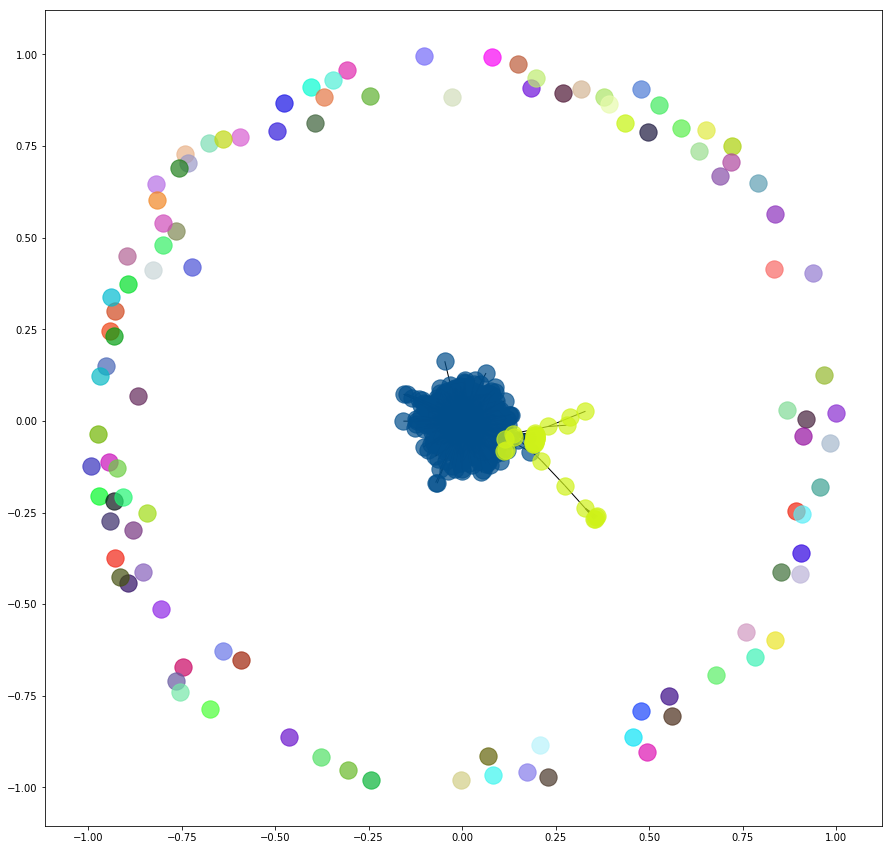

In [19]:
from matplotlib.pyplot import figure
import numpy

figure(figsize=(15,15))
pos = nx.spring_layout(G_sampled)
for community in list(communities_gn):
    nx.draw_networkx_nodes(G_sampled, pos=pos,
                           nodelist=community,
                           node_color=numpy.random.rand(3,),
                           alpha=0.7)
nx.draw_networkx_edges(G_sampled, pos=pos, edgelist=G_sampled.edges)

plt.show()

In [20]:
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
communities_gmc = greedy_modularity_communities(G_sampled)

communities_sum = 0

for community_gmc in communities_gmc:
    communities_sum += 1
    print("Community ", communities_sum)
    print(community_gmc)
    print("Liczność community: ", len(community_gmc), "\n")
    
print("Znaleziono communities: ", communities_sum)

Community  1
frozenset({880516946931859456, 726523736145465344, 821483424779276288, 821178996176064512, 822210115784806400, 791179412033118213, 1007274476860596229, 788055459169177601, 713522523489570817, 917501529480765441, 757001792815112193, 831044722177224706, 3020455940, 988667769024479239, 1055209982998863886, 1042006052693266438, 820432978392338440, 813579403024273408, 785453787087507456, 811768906301968384, 13396002, 23263297, 455024706, 807568509542797312, 767329581837783040, 2823913560, 4064788573, 372240477, 154003551, 591505507, 2718236783, 96133244, 2765123710, 763535755545284608, 817165541412638720, 710296989313994752, 756175794410557440, 821062432735039488, 711567845088432128, 23769223, 806632877668569088, 713127503351713793, 822462665910063105, 817581572291432450, 3518486666, 199768203, 381319309, 1595125903, 169566085, 3791902877, 18704545, 4227635364, 702909713164316672, 2848049341, 2596413645, 3272284375, 132022496, 1330411782, 925072203267432448, 924619976924979200,

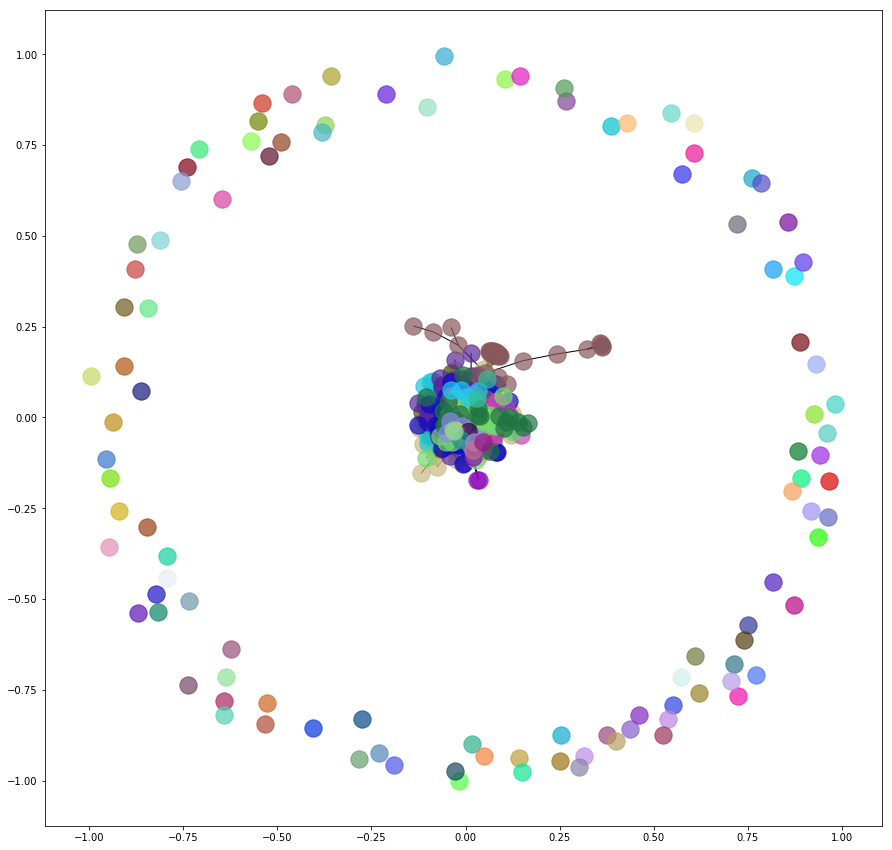

In [21]:
figure(figsize=(15,15))
pos = nx.spring_layout(G_sampled)
for community in communities_gmc:
    nx.draw_networkx_nodes(G_sampled, pos=pos,
                           nodelist=community,
                           node_color=numpy.random.rand(3,),
                           alpha=0.7)
nx.draw_networkx_edges(G_sampled, pos=pos, edgelist=G_sampled.edges)

plt.show()

In [22]:
sorted(G_sampled.degree, key=lambda x: x[1], reverse=True)[:10]


[(838114538868342787, 741),
 (2757695505, 621),
 (817382752731463680, 564),
 (959285851875196928, 324),
 (888492016010764288, 318),
 (885512012561870849, 306),
 (162301746, 271),
 (4165642155, 261),
 (17364806, 254),
 (719662077934243840, 241)]

In [23]:
degree_centrality = sorted(nx.degree_centrality(G_sampled).items(), key=lambda x: x[1], reverse=True)

In [24]:
degree_centrality[:10]

[(838114538868342787, 0.4018438177874187),
 (2757695505, 0.33676789587852496),
 (817382752731463680, 0.30585683297180044),
 (959285851875196928, 0.17570498915401303),
 (888492016010764288, 0.17245119305856835),
 (885512012561870849, 0.16594360086767895),
 (162301746, 0.14696312364425163),
 (4165642155, 0.14154013015184383),
 (17364806, 0.13774403470715835),
 (719662077934243840, 0.1306941431670282)]

In [25]:
betweenness_centrality = sorted(nx.betweenness_centrality(G_sampled).items(), key=lambda x: x[1], reverse=True)

In [26]:
betweenness_centrality[:10]

[(838114538868342787, 0.18142832929422514),
 (2757695505, 0.11228381982711678),
 (817382752731463680, 0.10548169490640794),
 (888492016010764288, 0.03595539406304269),
 (885512012561870849, 0.03352829174313694),
 (1011241130510471168, 0.03273044330896517),
 (959285851875196928, 0.03001125749492359),
 (162301746, 0.027460329913852027),
 (1238883301, 0.02407584318179163),
 (1661561491, 0.022134192649524258)]

In [27]:
edge_betweenness_centrality = sorted(nx.edge_betweenness_centrality(G_sampled).items(), key=lambda x: x[1], reverse=True)

In [28]:
edge_betweenness_centrality[:10]

[((1011241130510471168, 1238883301), 0.013528946441418836),
 ((741680976, 1011241130510471168), 0.008642294289771646),
 ((1011241130510471168, 403305133), 0.00712719491620079),
 ((403305133, 2329034473), 0.006112551364125356),
 ((762290549168701440, 2329034473), 0.0050967320953036),
 ((967617559376908289, 1011241130510471168), 0.004540736877175208),
 ((838114538868342787, 1238883301), 0.004352433614659816),
 ((802042941959045120, 1011241130510471168), 0.004236124714248784),
 ((967617559376908289, 817382752731463680), 0.004107539347120271),
 ((1011241130510471168, 826982179204915200), 0.004079737109735523)]

In [29]:
from networkx.algorithms.community import k_clique_communities
cliques = list(k_clique_communities(G_sampled, 7))

In [30]:
for clique in cliques:
    print(len(clique))
print('all cliques: ' + str(len(cliques)))

43
12
11
11
9
11
10
all cliques: 7


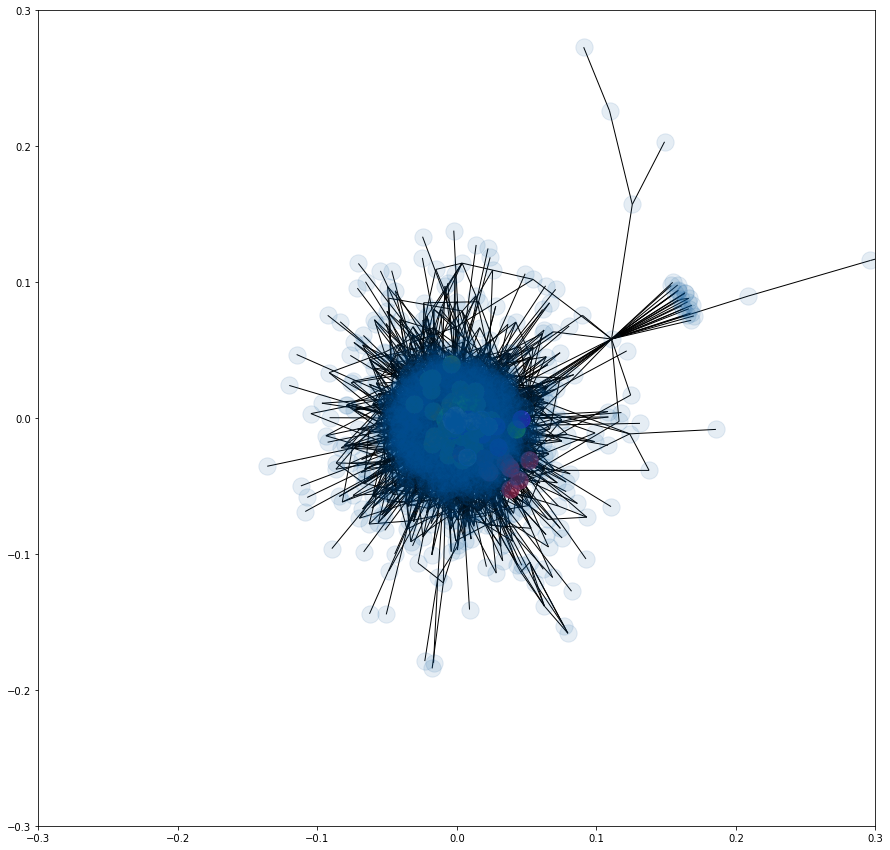

In [31]:
# Cliques and all ussers

figure(figsize=(15,15))
pos = nx.spring_layout(G_sampled)
for clique in cliques:
    nx.draw_networkx_nodes(G_sampled, pos=pos,
                           nodelist=clique,
                           node_color=numpy.random.rand(3,),
                           alpha=0.7)
nx.draw_networkx_nodes(G_sampled, pos=pos,
                           nodelist=G_sampled.nodes,
                           node_color=numpy.random.rand(3,),
                           alpha=0.1)
nx.draw_networkx_edges(G_sampled, pos=pos, nodelist=clique)

plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)

plt.show()

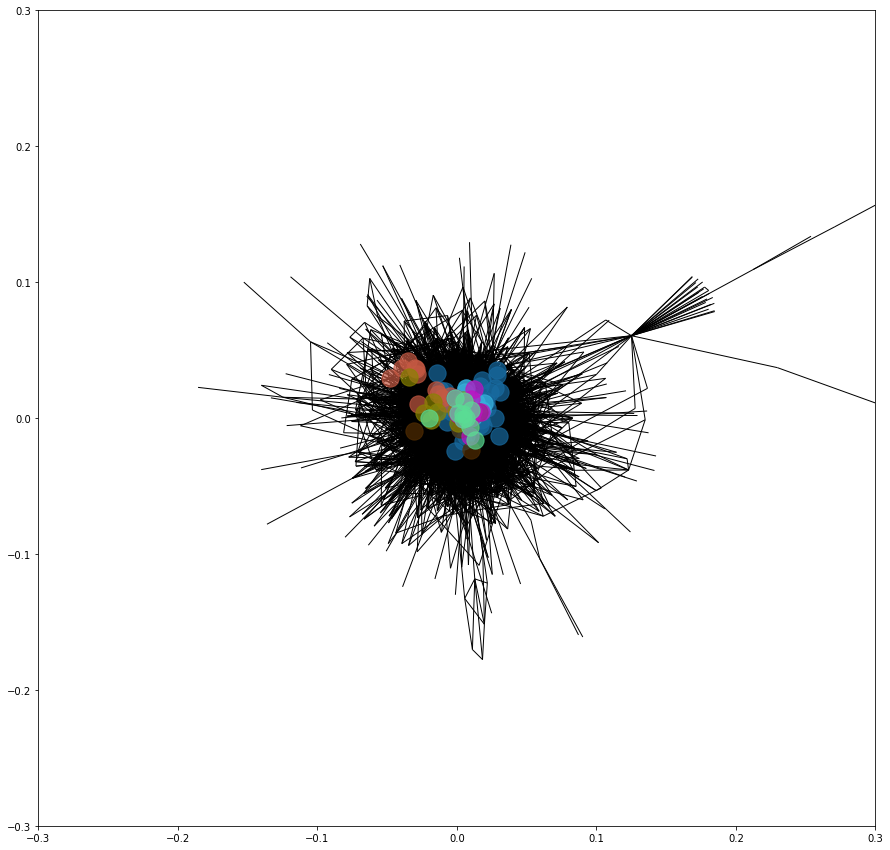

In [32]:
# Cliques

figure(figsize=(15,15))
pos = nx.spring_layout(G_sampled)
for clique in cliques:
    nx.draw_networkx_nodes(G_sampled, pos=pos,
                           nodelist=clique,
                           node_color=numpy.random.rand(3,),
                           alpha=0.7)
nx.draw_networkx_edges(G_sampled, pos=pos, nodelist=clique)

plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)

plt.show()

In [33]:
# Active users in distinct cliques

distinct_users_in_cliques = {}

for clique in cliques:
    for user in clique:
        if user in distinct_users_in_cliques:
            distinct_users_in_cliques[user] += 1
        else:
            distinct_users_in_cliques[user] = 1

In [34]:
# Users participating in 2 or more distinct cliques

top_users_in_cliques = sorted(distinct_users_in_cliques.items(), key=lambda x : x[1], reverse=True)
top_users_in_cliques = [(k,v) for k,v in top_users_in_cliques if v>=2]
print('users in 2+ cliques: ' + str(len(top_users_in_cliques)))
top_users_in_cliques

users in 2+ cliques: 15


[(838114538868342787, 4),
 (885512012561870849, 3),
 (162301746, 3),
 (839099917121511425, 3),
 (918534858871377920, 2),
 (894465693755637760, 2),
 (888522257693331457, 2),
 (3518486666, 2),
 (758101519891914761, 2),
 (3353061012, 2),
 (17364806, 2),
 (30579307, 2),
 (1049403240, 2),
 (167778891, 2),
 (719662077934243840, 2)]

In [35]:
# Get Vader analysis for selected users

user = top_users_in_cliques[10]
users = pd.read_sql_query('SELECT user.user_id AS id, user.user_name, tweet.tweet_id, vader.compound as vader_mood \
                            FROM user \
                             JOIN tweet ON tweet.user_id = user.user_id \
                             JOIN vader ON tweet.tweet_id = vader.id \
                             WHERE user.user_name = "' + str(user[0]) + '"', engine)
users

,id,user_name,tweet_id,vader_mood


In [36]:
# Map clique to clique_id
clique_dictionary = {}
id = 0
for clique in cliques:
    clique_dictionary[id] = clique
    id += 1

In [37]:
# Count user's influence per clique

def count_influence_per_clique(user,clique):
    clique_str = '('
    for member in clique:
        clique_str += str(member)
        clique_str += ', '
    clique_str = clique_str[:-2]   
    clique_str += ')'

    connections = pd.read_sql_query('SELECT user1.user_id AS user, user2.user_id AS retwitter \
                             FROM user AS user1 \
                             JOIN tweet ON tweet.user_id = user \
                             JOIN retweet ON retweet.source_tweet_id = tweet.tweet_id \
                             JOIN user AS user2 ON retweet.user_id = retwitter \
                             WHERE user1.user_id == ' + str(user) + ' \
                             AND retwitter IN ' + clique_str + '\
                             AND user != retwitter', engine)    
    return len(connections)

In [38]:
# Identify the most influential user per clicque

clique_id = 0
most_influential_user_per_clique = {}

for id,clique in clique_dictionary.items():
    user_influence = []
    for user in clique:
        influence = count_influence_per_clique(user,clique)
        user_influence.append((user,influence))
    
    user_influence.sort(key=lambda x: -x[1])
    most_influential_user_per_clique[id] = (user_influence[0][0],user_influence[0][1])
        

In [39]:
# (clique_id, user_id, measure of influence)

most_influential_user_per_clique

{0: (817382752731463680, 116),
 1: (950061320652509184, 34),
 2: (959285851875196928, 56),
 3: (838114538868342787, 25),
 4: (1661561491, 16),
 5: (3268675369, 32),
 6: (838114538868342787, 30)}

In [40]:
# Save cliques to file

for id, clique in clique_dictionary.items():
    file = open('clique/clique_'+str(id)+'.csv','w') 
    file.write('user_id\n')
    for user in clique:
        file.write(str(user)+'\n')

file.close() 

In [98]:
# Count betweenness_centrality for top influencer per clique

def bc_for_top_in_clique(id, clique, top_user):
    G_clique = G_sampled.subgraph(clique)
    betweenness_centrality = sorted(nx.betweenness_centrality(G_clique).items(), key=lambda x: x[1], reverse=True)
    top_betweenness_centrality = [item[1] for item in betweenness_centrality if item[0]==top_user[0]][0]
    # nx.draw(G_clique, labels=clique)
    return top_betweenness_centrality

In [106]:
table = BeautifulTable()
table.column_headers = ["clique", "clique_size", "top_user", "betweenness_centrality"]
for id, clique in clique_dictionary.items():
    table.append_row([str(id), str(len(clique)), str(most_influential_user_per_clique[id][0]), 
                      str(bc_for_top_in_clique(id, clique, most_influential_user_per_clique[id]))])
print(table)

+--------+-------------+--------------------+------------------------+
| clique | clique_size |      top_user      | betweenness_centrality |
+--------+-------------+--------------------+------------------------+
|   0    |     43      | 817382752731463680 |         0.059          |
+--------+-------------+--------------------+------------------------+
|   1    |     12      | 950061320652509184 |         0.039          |
+--------+-------------+--------------------+------------------------+
|   2    |     11      | 959285851875196928 |         0.037          |
+--------+-------------+--------------------+------------------------+
|   3    |     11      | 838114538868342787 |         0.003          |
+--------+-------------+--------------------+------------------------+
|   4    |      9      |     1661561491     |         0.018          |
+--------+-------------+--------------------+------------------------+
|   5    |     11      |     3268675369     |         0.037          |
+-----